#### Imports

In [1]:
from typing import Annotated, Literal, TypeVar
import mne
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import scipy
import pywt
import pandas as pd

mne.set_log_level('WARNING')
mne.set_config('MNE_BROWSE_RAW_SIZE', '16,8')

# Types

DType = TypeVar("DType", bound=np.generic)
ArrayN = Annotated[npt.NDArray[DType], Literal['N']]

# Get Data

#### Bonn University

In [2]:
def get_data_bonn(sets_to_read: list, time_segments: int, time_points: int) -> dict[str, np.ndarray]:
    """
    Returns data for all specified sets from the Bonn University dataset
    Data returned is in a dictionary with set letters as keys and 3d numpy arrays (time_segments, channels, time_points) as values

    Sets A and B are from healthy patients, while Sets C, D, and E are from epileptic patients.

    Sets C and D are seizure-free segments while set E is during a seizure.

    Each set contains 100 single-channel EEG segments of 23.6-sec duration. The EEGs were recorded at a sampling rate of 173.61 Hz with 12-bit resolution over a 10 mV range.
    """
    data = dict()

    # maps from set_letter to set_letter_alternate (for the filenames)
    sets_to_file_prefixes = {
        'A': 'Z',
        'B': 'O',
        'C': 'N',
        'D': 'F',
        'E': 'S'
    }

    for set in sets_to_read:
        if set not in sets_to_file_prefixes:
            continue

        set_letter_alternate = sets_to_file_prefixes[set]

        set_data = np.zeros((time_segments, 1, time_points))
        for i in range(time_segments):
            filename = f'data/bonn/SET {set}/{set_letter_alternate}{str(i+1).zfill(3)}.txt'
            z = np.loadtxt(filename)
            set_data[i][0] = z[:time_points]

        data[set] = set_data

    return data

#### AHEPA

In [3]:
def get_data_ahepa():
    """
    https://openneuro.org/datasets/ds004504/versions/1.0.7
    A dataset of EEG recordings from: Alzheimer's disease, Frontotemporal dementia and Healthy subjects
    """
    raws_all_sets = {}
    # dictionary from set to 3d numpy array (time_segments, channels, time_points)

    participants = pd.read_csv('data/AHEPA/participants.tsv', sep='\t')


    for disorder in {'F', 'C'}:
        DISORDER = participants[participants['Group'] == disorder]

        raws_one_disorder = []
        for participant_id in DISORDER['participant_id']:
            filename = f'data/AHEPA/derivatives/{participant_id}/eeg/{participant_id}_task-eyesclosed_eeg.set'   # read derivatives folder for preprocessed data
            raw = mne.io.read_raw_eeglab(filename, preload=True)
            # raw.plot()
            raws_one_disorder.append(raw)

        raws_all_sets[disorder] = raws_one_disorder

    return raws_all_sets

raws_all_sets = get_data_ahepa()
print(raws_all_sets['F'])

/var/folders/jn/90br8jjn68b1psqfzrd83ry40000gn/T/ipykernel_80156/2565375832.py:18: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filename, preload=True)
/var/folders/jn/90br8jjn68b1psqfzrd83ry40000gn/T/ipykernel_80156/2565375832.py:18: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filename, preload=True)
/var/folders/jn/90br8jjn68b1psqfzrd83ry40000gn/T/ipykernel_80156/2565375832.py:18: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filename, preload=True)
/var/folders/jn/90br8jjn68b1psqfzrd83ry40000gn/T/ipykernel_80156/2565375832.py:18: RuntimeWarning: The data contains 'boundary' events, indicating data

[<RawEEGLAB | sub-066_task-eyesclosed_eeg.set, 19 x 274880 (549.8 s), ~39.9 MB, data loaded>, <RawEEGLAB | sub-067_task-eyesclosed_eeg.set, 19 x 321550 (643.1 s), ~46.6 MB, data loaded>, <RawEEGLAB | sub-068_task-eyesclosed_eeg.set, 19 x 286550 (573.1 s), ~41.6 MB, data loaded>, <RawEEGLAB | sub-069_task-eyesclosed_eeg.set, 19 x 318050 (636.1 s), ~46.1 MB, data loaded>, <RawEEGLAB | sub-070_task-eyesclosed_eeg.set, 19 x 239550 (479.1 s), ~34.8 MB, data loaded>, <RawEEGLAB | sub-071_task-eyesclosed_eeg.set, 19 x 309450 (618.9 s), ~44.9 MB, data loaded>, <RawEEGLAB | sub-072_task-eyesclosed_eeg.set, 19 x 328710 (657.4 s), ~47.7 MB, data loaded>, <RawEEGLAB | sub-073_task-eyesclosed_eeg.set, 19 x 427290 (854.6 s), ~62.0 MB, data loaded>, <RawEEGLAB | sub-074_task-eyesclosed_eeg.set, 19 x 507250 (1014.5 s), ~73.6 MB, data loaded>, <RawEEGLAB | sub-075_task-eyesclosed_eeg.set, 19 x 374090 (748.2 s), ~54.3 MB, data loaded>, <RawEEGLAB | sub-076_task-eyesclosed_eeg.set, 19 x 409400 (818.8 s),

/var/folders/jn/90br8jjn68b1psqfzrd83ry40000gn/T/ipykernel_80156/2565375832.py:18: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filename, preload=True)
/var/folders/jn/90br8jjn68b1psqfzrd83ry40000gn/T/ipykernel_80156/2565375832.py:18: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filename, preload=True)


#### Get Data

In [4]:
time_segments, channels, time_points = 100, 1, 4096
freq = 173.61

sets_to_use = ['A', 'B', 'C', 'D', 'E']
data_all_sets = get_data_bonn(sets_to_use, time_segments=time_segments, time_points=time_points)
print(data_all_sets['A'].shape)

(100, 1, 4096)


#### Create mne.Raw objects

In [5]:
raws_all_sets = {}
for set in sets_to_use:

    raw_one_set = []
    for time_segment in data_all_sets[set]:
        info = mne.create_info(
            ch_names=[f'c{i}' for i in range(channels)],
            sfreq=freq,
            ch_types='eeg',
        )
        raw_one_set.append(mne.io.RawArray(time_segment, info))

    raws_all_sets[set] = raw_one_set

# Preprocessing

#### Filtering

In [6]:
for set in raws_all_sets:
    # if set != 'A': break
    for i, time_segment in enumerate(raws_all_sets[set]):
        # if i > 0: break
        # raws_all_sets[set][i].copy().compute_psd().plot()

        # raws_all_sets[set][i].copy().plot(duration=5, n_channels=15, scalings=500)

        raws_all_sets[set][i] = raws_all_sets[set][i].notch_filter(freqs=50)
        raws_all_sets[set][i] = raws_all_sets[set][i].filter(l_freq=1, h_freq=50, filter_length=4095)

        data_all_sets[set][i] = raws_all_sets[set][i]._data

        # raws_all_sets[set][i].copy().compute_psd().plot();
        # raws_all_sets[set][i].copy().plot(duration=5, n_channels=15, scalings=500);

#### Segmentation into intervals

# Feature Extraction

#### Define 1D multilevel DWT function for each time segment (using Daubechies 4)

In [7]:
def discrete_wavelet_transform(data):
    # 1D multilevel DWT
    cA4, cD4, cD3, cD2, cD1 = pywt.wavedec(data, wavelet='db4', level=4)
    # low frequencies => high time resolution, low freq resolution
    # high frequences => low time resolution, high freq resolution
    # print(cA4.shape)  # 0.1-4 Hz   60
    # print(cD4.shape)  # 4-8 Hz     60
    # print(cD3.shape)  # 8-15 Hz    114
    # print(cD2.shape)  # 15-30 Hz   222
    # print(cD1.shape)  # 30-60 Hz   437
    
    # plt.plot(cD1.flatten())
    # plt.xlabel('Sample')
    # plt.ylabel('Amplitude')
    # plt.title('cD1')
    # plt.show()
    return cA4, cD4, cD3, cD2, cD1

#### Define feature vector functions

In [8]:
def variance(data) -> ArrayN[np.float64]:
    variance_data = np.var(data, axis=1)
    return variance_data  # shape (# channels,)


def standard_deviation(data) -> ArrayN[np.float64]:
    """
    measures the amount of variation of a set of values
    """
    std_data = np.std(data, axis=1)
    return std_data


def kurtosis(data) -> ArrayN[np.float64]:
    """
    measure of the 'tailedness' of the data or outliers
    """
    # fisher = True is default, which subtracts 3 from the final value
    return scipy.stats.kurtosis(data, axis=1, fisher=False)


def nn_shannon_entropy(data) -> ArrayN[np.float64]:
    """
    measures the uncertainty of the data (or how surprising it is)
    """
    # squared so log is never taken of a negative number in the data
    squared = data**2
    output = np.sum(squared * np.log(squared), axis=1)
    return output

    # output2 = np.sum(data * np.log(data), axis=1)
    # return output2   # returns nan because there are negative numbers
    return scipy.stats.entropy(data, axis=1)  # returns -inf


def logarithmic_band_power(data) -> ArrayN[np.float64]:
    """
    """
    n = data.shape[1]
    return np.log(np.sum(data**2, axis=1) / n)



def compute_features_(data):
    # TODO: instead of 5 features for every dwt output do something else
    pass


def compute_features(data):  # -> shape (100, 5)
    return np.array([
        logarithmic_band_power(data),
        standard_deviation(data),
        variance(data),
        kurtosis(data),
        nn_shannon_entropy(data)
    ], dtype=np.float64).T

#### Define feature vector graphing functions

In [9]:
BandType = Literal['A4', 'D4', 'D3', 'D2', 'D1']
FeatureType = Literal['LBP', 'Std', 'Var', 'Kur', 'SE']

# GETS FEATURE FROM 25 LENGTH FEATURE VECTORS


def get_feature(
    feature_vector: np.ndarray,
    band: BandType,
    feature: FeatureType
) -> np.float64:

    bands = ['A4', 'D4', 'D3', 'D2', 'D1']
    features = ['LBP', 'Std', 'Var', 'Kur', 'SE']

    row = bands.index(band)
    col = features.index(feature)

    return feature_vector[
        # channel * len(bands) * len(features)
        row * len(features)
        + col
    ]


def graph_feature_vectors(feature_vectors_all_sets: dict[str, np.ndarray], band_x: BandType, band_y: BandType, feature: FeatureType, flatten_channels=False, graph_individual_channels: bool = False):
    # colors = ['blue', 'green', 'yellow', 'red', 'black']
    colors = ['blue', 'blue', 'red', 'red', 'red']

    # Loop through each available set
    for i, set in enumerate(feature_vectors_all_sets):
        # shape (# tsegments, # channels, 25)
        feature_vectors = feature_vectors_all_sets[set]

        # Loop through each time segment
        for feature_vector in feature_vectors:  # shape (# channels, 25)
            if graph_individual_channels and not flatten_channels:
                # Loop thru channels and only graph specific parts of each feature vector
                for channel in range(channels):
                    x = get_feature(
                        feature_vector[channel], band=band_x, feature=feature)
                    y = get_feature(
                        feature_vector[channel], band=band_y, feature=feature)

                    plt.scatter(x, y, color=colors[i], s=4)
            else:
                if flatten_channels:
                    x = get_feature(
                        feature_vector, band=band_x, feature=feature)
                    y = get_feature(
                        feature_vector, band=band_y, feature=feature)
                else:
                    x = get_feature(
                        feature_vector[0], band=band_x, feature=feature)
                    y = get_feature(
                        feature_vector[0], band=band_y, feature=feature)
                plt.scatter(x, y, color=colors[i], s=4)

    plt.xlabel(f'{band_x} {feature}')
    plt.ylabel(f'{band_y} {feature}')
    plt.show()

#### Compute feature vector for each segment

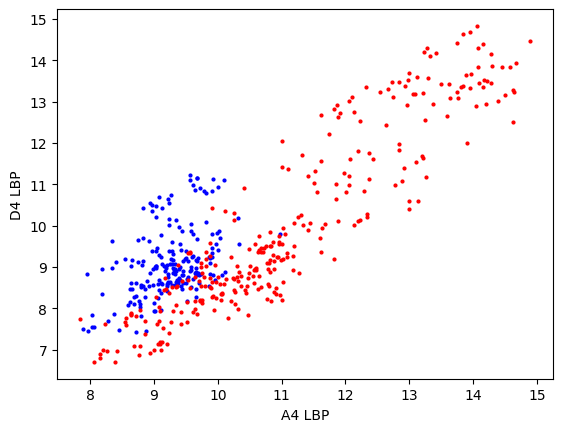

In [10]:
# set → ndarray shape (# tsegments, # channels, 25) or (# tsegments, # channels * 25)
feature_vectors_all_sets: dict[str, np.ndarray] = {}
flatten_channels = True

for set in data_all_sets:
    tsegments = data_all_sets[set]   # shape (# tsegments, # channels, 4096)

    segment_feature_vectors = []
    for segment_data in tsegments:  # shape (# channels, 4096)
        # Perform discrete wavelet transform on data
        dwt_outputs = discrete_wavelet_transform(
            data=segment_data)   # shape (# channels, <4096)

        # 5 features are extracted (LBP, SD, var, kur, SE) from each DWT-extracted freq band
        outputs = np.hstack([compute_features(dwt_output)
                            for dwt_output in dwt_outputs])  # (# channels, 25)
        if flatten_channels:
            segment_feature_vectors.append(
                outputs.flatten())  # shape (# channels * 25)
        else:
            segment_feature_vectors.append(outputs)  # shape (# channels, 25)

    feature_vectors_all_sets[set] = np.array(segment_feature_vectors)

graph_feature_vectors(feature_vectors_all_sets, band_x='A4', band_y='D4', feature='LBP', flatten_channels=flatten_channels, graph_individual_channels=True)   # A4 = delta = 0.1-4 Hz, D4 = theta = 4-8 Hz

# Classification

#### Attach labels

In [13]:
import pandas as pd

set_mapping = {
    'A': 0,
    'B': 0,
    'C': 1,
    'D': 1,
    'E': 1
}  # 1 = epileptic, 0 = healthy     E is seizure

print(feature_vectors_all_sets['A'].shape)

data = pd.DataFrame(np.vstack([feature_vectors_all_sets[set] for set in feature_vectors_all_sets]))
data.columns = [f'{band}_{feature}' for band in ['A4', 'D4', 'D3', 'D2', 'D1'] for feature in ['LBP', 'Std', 'Var', 'Kur', 'SE']]
data['Set'] = sum([[set_mapping[set]] * 100 for set in feature_vectors_all_sets], [])

X = data.drop('Set', axis=1)
y = data['Set'].values
print(data.head())
print(X.shape, y.shape)

(100, 25)
     A4_LBP      A4_Std        A4_Var    A4_Kur         A4_SE    D4_LBP  \
0  9.320015  105.610479  11153.573271  3.227087  2.945328e+07  8.926857   
1  9.478054  114.317478  13068.485797  3.157692  3.504191e+07  9.201274   
2  9.567521  119.539916  14289.791549  2.922802  3.854536e+07  8.894679   
3  9.120057   95.586178   9136.717469  3.110568  2.363312e+07  9.079039   
4  9.335510  106.456613  11333.010368  2.663844  2.970025e+07  8.834972   

      D4_Std       D4_Var    D4_Kur         D4_SE  ...     D2_Std      D2_Var  \
0  86.772970  7529.548403  3.399866  1.928472e+07  ...  17.093892  292.201151   
1  99.508310  9901.903720  3.627034  2.600630e+07  ...  24.125273  582.028812   
2  85.032335  7230.497925  3.521433  1.848408e+07  ...  18.996412  360.863676   
3  93.485403  8739.520593  3.352153  2.267803e+07  ...  29.695417  881.817772   
4  82.073913  6736.127123  4.662324  1.772766e+07  ...  19.003171  361.120515   

     D2_Kur         D2_SE    D1_LBP    D1_Std     D1

#### K-nearest neighbors

In [12]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


def stratified_train_test_validation_split(X, y, ratio_train=0.8, ratio_val=0.1, ratio_test=0.1):
    if ratio_train + ratio_val + ratio_test != 1:
        return
    X_remaining, X_test, y_remaining, y_test = train_test_split(
        X, y, test_size=ratio_test, random_state=1)

    # Produces train and val splits.
    X_train, X_val, y_train, y_val = train_test_split(
        X_remaining, y_remaining, test_size=ratio_val / (1 - ratio_test), random_state=1)

    return X_train, X_val, X_test, y_train, y_val, y_test


def k_fold_cross_validation(X, y, k_folds=10):
    """
    k-fold cross validation
    inputs: X, y, k_folds
    """
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
    kf = KFold(n_splits=k_folds, random_state=1, shuffle=True)
    kf.get_n_splits(X)
    accuracy = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        accuracy_this_fold = knn(X_train, y_train, X_test, y_test, k=5)
        accuracy += accuracy_this_fold
        print(accuracy_this_fold)
    return accuracy / k_folds


def knn(X_train, y_train, X_test, y_test, k):
    """
    normal knn classifier
    determines the best k value and returns the best accuracy
    inputs: train test split
    """
    # https://www.tutorialspoint.com/scikit_learn/scikit_learn_kneighbors_classifier.htm
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    # confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

    return metrics.accuracy_score(y_test, y_pred)


def _find_best_k(X_train, y_train, X_test, y_test):
    k_range = range(1, 15)
    scores = {}
    scores_list = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        scores[k] = metrics.accuracy_score(y_test, y_pred)
        scores_list.append(metrics.accuracy_score(y_test, y_pred))

    # Plot the accuracy for different k values
    plt.plot(k_range, scores_list)
    plt.xlabel("k")
    plt.ylabel("Accuracy")

    return max(scores, key=scores.get)


# --------------------- single split KNN ---------------------
# X_train, X_val, X_test, y_train, y_val, y_test = stratified_train_test_validation_split(
#     X, y)
# knn_accuracy = knn(X_train, y_train, X_test, y_test)
# print(knn_accuracy)

# --------------------- k-fold cross validation ---------------------
k_fold_accuracy = k_fold_cross_validation(X.values, y, k_folds=10)
print(k_fold_accuracy)


0.92
0.98
0.92
0.96
0.9
0.98
1.0
0.98
1.0
0.96
0.9600000000000002
